In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import multiprocessing

# Disable CUDA because only one gpu device allows only a single chain
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)
import jax

jax.default_backend()
jax.devices()

2023-07-19 21:48:24.341229: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]

In [6]:
from yomi_skill.model import YomiModel, weight_by
from yomi_skill.models import *
from yomi_skill.models.mu_glicko import *
from yomi_skill.yomi import historical_record
import pandas
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tempfile

from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, cross_validate

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [7]:
fit_dir = tempfile.mkdtemp()

In [8]:
tournament_games = historical_record.latest_tournament_games()
sirlin_games = historical_record.sirlin_db()
games = pandas.concat([tournament_games, sirlin_games]).reset_index(drop=True)

games

,match_date,player_1,character_1,win,character_2,player_2,public
0,2014-07-06 00:00:00,Jengajam,menelker,0,setsuki,fodazd,True
1,2014-07-06 00:00:00,MadKing,quince,1,setsuki,CKR,True
2,2014-07-06 00:00:00,Raziek,zane,1,quince,MadKing,True
3,2014-07-06 00:00:00,Raziek,zane,1,quince,MadKing,True
4,2014-07-06 00:00:00,Raziek,zane,1,quince,MadKing,True
...,...,...,...,...,...,...,...
120301,2015-09-07 19:11:01,DarkSephiroth,menelker,0,valerie,BONZAI,False
120302,2015-09-07 19:09:31,Kirandio,degrey,0,menelker,pfiidude,False
120303,2015-09-07 19:17:11,hartley,valerie,0,rook,EricF,False
120304,2015-09-07 19:17:43,DarkSephiroth,menelker,0,valerie,BONZAI,False


In [9]:
games = historical_record.augment_dataset(games)

Constructing PC category


In [10]:
min_games = 0
warmup = 500
samples = 1000

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    games, games.win.astype('int'),
)

In [12]:
MODELS = {
    model.model_name: model
    for model_type in YomiModel.__subclasses__()
    for model in model_type.__subclasses__()
}

In [13]:
MODELS

{'mu_pc_glicko': yomi_skill.models.mu_pc_glicko.MUPCGlicko,
 'pc_elo': yomi_skill.models.pc_elo.PCElo,
 'mu_pc_elo_c': yomi_skill.models.mu_pc_elo_c.MUPCEloC,
 'char_skill_skelo_skill_deficit': yomi_skill.models.char_skill_skelo_skill_deficit.CharSkillSkeloSkillDeficit,
 'mu': yomi_skill.models.mu_only.MUOnly,
 'glicko': yomi_skill.models.glicko.Glicko,
 'elo': yomi_skill.models.elo.Elo,
 'mu_pc_elo_vol': yomi_skill.models.mu_pc_elo_vol.MUPCEloVol,
 'char_skill_glicko_skill_deficit': yomi_skill.models.char_skill_glicko_skill_deficit.CharSkillGlickoSkillDeficit,
 'mu_pc_elo': yomi_skill.models.mu_pc_elo.MUPCElo,
 'full': yomi_skill.models.full.Full,
 'mu_elo': yomi_skill.models.mu_elo.MUElo,
 'mu_glicko': yomi_skill.models.mu_glicko.MUGlicko,
 'pc_glicko': yomi_skill.models.pc_glicko_only.PCGlicko}

In [14]:
model_names = [
    'full',
    # 'mu',
    # 'elo',
    # 'mu_elo',
    # 'pc_elo',
    # 'mu_pc_elo',
    # 'mu_pc_elo_vol',
    # 'mu_pc_elo_c',
    # 'glicko',
    # 'mu_glicko',
    # 'pc_glicko',
    # 'mu_pc_glicko',
]
models = {model_name: MODELS[model_name](min_games=min_games, warmup=warmup, samples=samples) for model_name in model_names}

In [63]:
pipelines = {}
pipelines['full'] = models['full'].pipeline(
        transform__elo__initial_time=games.match_date.min(),
        transform__pc_elo__initial_time=games.match_date.min(),
        model__min_games=min_games,
        model__warmup=warmup,
        model__samples=samples,
    )

pipelines['full2'] = models['full'].pipeline(
        transform__elo__initial_time=games.match_date.min(),
        transform__pc_elo__initial_time=games.match_date.min(),
        model__min_games=min_games,
        model__warmup=warmup,
        model__samples=samples,
        transform__elo__default_k=16,
        transform__pc_elo__default_k=1
    )
# pipelines['mu_elo'] = models['mu_elo'].pipeline(
#         transform__elo__initial_time=games.match_date.min(),
#         model__min_games=min_games,
#         model__warmup=warmup,
#         model__samples=samples,
#     )
# pipelines['mu_pc_elo'] = models['mu_pc_elo'].pipeline(
#         transform__pc_elo__initial_time=games.match_date.min(),
#         model__min_games=min_games,
#         model__warmup=warmup,
#         model__samples=samples,
#     )

In [64]:
from sklearn import set_config
set_config(transform_output="pandas")

In [65]:
for model_name in ['full2']:
    pipelines[model_name].fit(
        X_train,
        y_train,
        # sample_weight=X_train[f'{models[model_name].weight_key}_weight']
    )

Compiling...
Compilation time =  0:00:01.332587
Sampling...
Sampling time =  0:00:05.613854
Transforming variables...
Transformation time =  0:02:46.611822


In [84]:
from yomi_skill.render import *
render = YomiRender(pipelines['full2']['model'])
display(pipelines['full2']['model'].data_)
filename = render.render_matchup_comparator('yomi', 'site/index.html')
print(filename)


,elo__prob,elo__r1,elo__r2,pc_elo__prob,pc_elo__r1,pc_elo__r2,min_games__player_1_orig,min_games__player_2_orig,min_games__player_1,min_games__player_2,min_games__min_games_player_1,min_games__min_games_player_2,matchup__mup,matchup__character_1,matchup__character_2,matchup__non_mirror,render__match_date,render__win,render__public
25764,0.584750,1536.328240,1476.863928,0.508436,1503.869073,1498.006466,andrewgr,rodohk,andrewgr,rodohk,False,False,gwen-persephone,gwen,persephone,1,2013-06-17 02:44:22,1,False
33479,0.363122,1493.929025,1591.530259,0.498547,1499.500014,1500.509701,Majidah,Juushichi,Majidah,Juushichi,False,False,quince-vendetta,quince,vendetta,1,2013-07-18 23:54:36,1,False
96130,0.401829,1562.516169,1631.630098,0.504746,1503.966541,1500.668608,abura0,Legion,abura0,Legion,False,False,argagarg-grave,argagarg,grave,1,2015-05-11 12:07:55,0,False
41183,0.613612,1552.593114,1472.244793,0.502863,1500.000000,1498.010742,SIN1024,murder-puniu-inc,SIN1024,murder-puniu-inc,False,False,rook-vendetta,rook,vendetta,1,2013-09-26 15:20:39,1,False
41854,0.491688,1534.736873,1540.513465,0.495369,1499.319347,1502.537277,RoyalLance,N-A-F-T-W,RoyalLance,N-A-F-T-W,False,False,grave-valerie,grave,valerie,1,2013-10-04 03:33:40,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,0.390425,1475.352897,1552.749012,0.502080,1500.000000,1498.554611,[-MAV-]FrozenStorm,zorrb,[-MAV-]FrozenStorm,zorrb,False,False,lum-quince,lum,quince,1,2015-05-17 03:12:51,0,False
97021,0.334581,1509.087805,1628.525651,0.474820,1500.517513,1518.029324,porygon3,Bomber678,porygon3,Bomber678,False,False,grave-troq,grave,troq,1,2015-05-12 05:25:09,0,False
29435,0.448142,1443.134203,1479.298607,0.498558,1499.009776,1500.011724,qauz,Offler,qauz,Offler,False,False,gwen-gwen,gwen,gwen,0,2013-06-29 07:07:41,1,False
61718,0.466005,1448.262263,1471.921156,0.499493,1496.701411,1497.053516,Card Gamer,ap49,Card Gamer,ap49,False,False,gloria-midori,gloria,midori,1,2014-06-23 23:13:27,0,False


Computing per-player data for 338 players
Computing matchup dict
<xarray.DataArray 'mu' (matchup: 210)>
array([-9.31968191e-03,  1.54172823e-01, -2.16335698e-02, -1.78288575e-01,
       -2.75240626e-01,  1.13437053e-01,  2.46602893e-01,  2.68723084e-01,
        1.71160060e-01,  5.72927538e-02,  5.64531052e-02,  4.10014430e-01,
       -2.37895162e-02, -1.38172861e-01,  2.61223959e-01,  2.12258385e-01,
       -6.96022587e-02,  2.01323340e-01,  2.35872523e-02, -2.62852106e-01,
        6.25013338e-03, -1.39211459e-01, -4.39788611e-01, -2.27696862e-01,
       -3.74437208e-01, -1.75422464e-01, -8.43400581e-02, -1.22527312e-01,
       -8.82516375e-02,  2.28618275e-01, -4.59362230e-01,  4.12897081e-01,
        1.05703850e-01,  1.96418662e-01, -1.72635097e-01,  1.81767422e-02,
       -1.42993010e-01, -7.36330767e-02, -2.30262099e-01, -6.70780169e-04,
       -4.45399072e-02,  1.29800005e-01,  8.37851119e-02,  4.82315799e-01,
        2.93672726e-01,  3.52973304e-01,  3.23218087e-01,  2.11708553e-

In [41]:
pred_test = {
    model_name: pipelines[model_name].predict_proba(X_test)[:, 1]
    for model_name in ['full', 'full2']
    if hasattr(pipelines[model_name]['model'], 'inf_data_')
}

In [42]:
df_pred_test = pandas.DataFrame(pred_test)

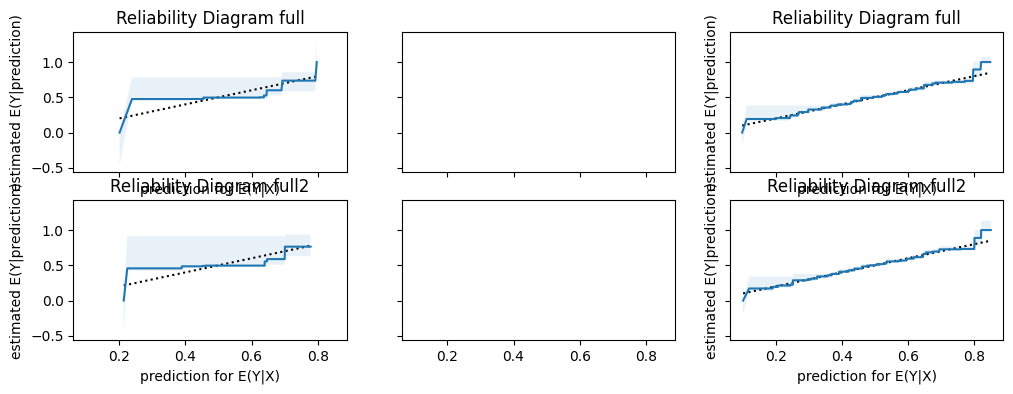

In [43]:
import matplotlib.pyplot as plt
from model_diagnostics.calibration import compute_bias, plot_bias, plot_reliability_diagram
fig, axes = plt.subplots(ncols=3, nrows=len(pred_test), figsize=(12, 4*len(model_names)), sharex=True, sharey=True)
mirror_matches = (X_test.character_1 == X_test.character_2).to_numpy()

for i, model_name in enumerate(pred_test):
    plot_reliability_diagram(
        y_obs=y_test[mirror_matches],
        y_pred=df_pred_test[model_name][mirror_matches],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[i][0],
    )
    plot_reliability_diagram(
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[i][2],
    )

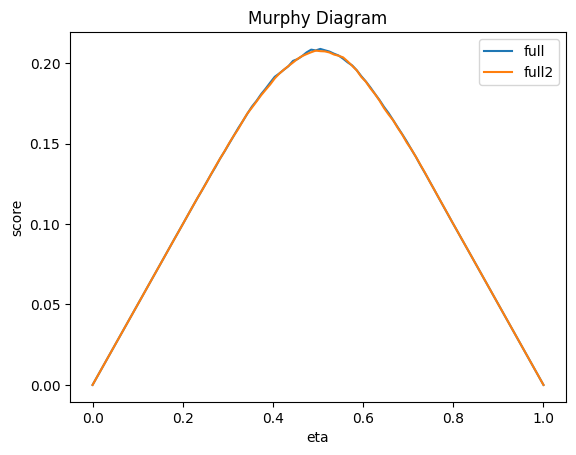

In [44]:
from model_diagnostics.scoring import SquaredError, plot_murphy_diagram

ax = plot_murphy_diagram(
    y_obs=y_test,
    y_pred=df_pred_test,
)

In [45]:
from model_diagnostics.scoring import SquaredError, decompose
import polars as pl

df_list = []
for model_name in df_pred_test:
    df = decompose(
        scoring_function=SquaredError(),
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
        # weights=X_test[models[model_name].weight_key + '_weight'],
    )
    df = df.with_columns(pl.lit(model_name).alias("model"))
    df_list.append(df)
pl.concat(df_list)[:, [-1, 0, 1, 2, 3]]


model,miscalibration,discrimination,uncertainty,score
str,f64,f64,f64,f64
"""full""",0.00051,0.011516,0.25,0.238994
"""full2""",0.000548,0.011807,0.25,0.238741


In [27]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import loguniform, uniform
from sklearn.model_selection import GridSearchCV
search = HalvingRandomSearchCV(
    pipelines['full'],
    {
        'transform__elo__default_k': loguniform(15, 80),
        'transform__pc_elo__default_k': loguniform(1, 80),
    },
    scoring='neg_brier_score',
    verbose=2,
    n_candidates=80,
    min_resources='exhaust')
search.fit(games, games.win)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 4455
max_resources_: 120306
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 4455
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Compiling...
Compilation time =  0:00:02.466061
Sampling...
Sampling time =  0:00:06.310433
Transforming variables...
Transformation time =  0:00:03.118715
[CV] END transform__elo__default_k=32.471244314414015, transform__pc_elo__default_k=10.132438152022768; total time=  13.9s
Compiling...
Compilation time =  0:00:03.060107
Sampling...


KeyboardInterrupt: 

In [46]:
import arviz
for model in df_pred_test:
    print(model)
    display(pipelines[model]['model'].data_)
    display(arviz.summary(pipelines[model]['model'].inf_data_))

full


,elo__prob,elo__r1,elo__r2,pc_elo__prob,pc_elo__r1,pc_elo__r2,min_games__player_1_orig,min_games__player_2_orig,min_games__player_1,min_games__player_2,min_games__min_games_player_1,min_games__min_games_player_2,matchup__mup,matchup__character_1,matchup__character_2,matchup__non_mirror,remainder__win,remainder__public
25764,0.596580,1539.411089,1471.446868,0.611831,1541.541888,1462.497966,andrewgr,rodohk,andrewgr,rodohk,False,False,gwen-persephone,gwen,persephone,1,1,False
33479,0.337980,1492.868228,1609.660298,0.477242,1489.872501,1505.697490,Majidah,Juushichi,Majidah,Juushichi,False,False,quince-vendetta,quince,vendetta,1,1,False
96130,0.395687,1574.498975,1648.063301,0.546535,1569.907769,1537.478181,abura0,Legion,abura0,Legion,False,False,argagarg-grave,argagarg,grave,1,0,False
41183,0.629210,1557.596633,1465.729463,0.551729,1500.000000,1463.925908,SIN1024,murder-puniu-inc,SIN1024,murder-puniu-inc,False,False,rook-vendetta,rook,vendetta,1,1,False
41854,0.479608,1540.595292,1554.772809,0.445469,1510.766154,1548.809565,RoyalLance,N-A-F-T-W,RoyalLance,N-A-F-T-W,False,False,grave-valerie,grave,valerie,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,0.389537,1471.910401,1549.954389,0.522584,1500.000000,1484.296678,[-MAV-]FrozenStorm,zorrb,[-MAV-]FrozenStorm,zorrb,False,False,lum-quince,lum,quince,1,0,False
97021,0.333657,1511.003305,1631.162642,0.314117,1511.299757,1646.963166,porygon3,Bomber678,porygon3,Bomber678,False,False,grave-troq,grave,troq,1,0,False
29435,0.443468,1437.446955,1476.897881,0.471024,1484.116584,1504.274026,qauz,Offler,qauz,Offler,False,False,gwen-gwen,gwen,gwen,0,1,False
61718,0.443668,1430.604317,1469.914942,0.518500,1476.082303,1463.221365,Card Gamer,ap49,Card Gamer,ap49,False,False,gloria-midori,gloria,midori,1,0,False


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[argagarg-argagarg],-0.005,0.491,-0.902,0.916,0.005,0.009,11261.0,2664.0,1.00
mu[argagarg-bbb],0.147,0.113,-0.066,0.361,0.001,0.001,10092.0,2539.0,1.00
mu[argagarg-degrey],-0.028,0.085,-0.182,0.130,0.001,0.002,8442.0,2553.0,1.00
mu[argagarg-geiger],-0.181,0.096,-0.361,0.000,0.001,0.001,11695.0,2834.0,1.00
mu[argagarg-gloria],-0.287,0.097,-0.472,-0.109,0.001,0.001,9801.0,2487.0,1.00
...,...,...,...,...,...,...,...,...,...
mu[vendetta-vendetta],0.003,0.520,-1.008,0.924,0.005,0.010,9668.0,2403.0,1.00
mu[vendetta-zane],-0.124,0.100,-0.317,0.059,0.001,0.001,12468.0,2847.0,1.01
mu[zane-zane],0.007,0.502,-0.959,0.918,0.004,0.011,12823.0,2263.0,1.00
pc_elo_sum_intercept,0.191,0.023,0.148,0.233,0.000,0.000,6669.0,3175.0,1.00


full2


,elo__prob,elo__r1,elo__r2,pc_elo__prob,pc_elo__r1,pc_elo__r2,min_games__player_1_orig,min_games__player_2_orig,min_games__player_1,min_games__player_2,min_games__min_games_player_1,min_games__min_games_player_2,matchup__mup,matchup__character_1,matchup__character_2,matchup__non_mirror,remainder__win,remainder__public
25764,0.584750,1536.328240,1476.863928,0.508436,1503.869073,1498.006466,andrewgr,rodohk,andrewgr,rodohk,False,False,gwen-persephone,gwen,persephone,1,1,False
33479,0.363122,1493.929025,1591.530259,0.498547,1499.500014,1500.509701,Majidah,Juushichi,Majidah,Juushichi,False,False,quince-vendetta,quince,vendetta,1,1,False
96130,0.401829,1562.516169,1631.630098,0.504746,1503.966541,1500.668608,abura0,Legion,abura0,Legion,False,False,argagarg-grave,argagarg,grave,1,0,False
41183,0.613612,1552.593114,1472.244793,0.502863,1500.000000,1498.010742,SIN1024,murder-puniu-inc,SIN1024,murder-puniu-inc,False,False,rook-vendetta,rook,vendetta,1,1,False
41854,0.491688,1534.736873,1540.513465,0.495369,1499.319347,1502.537277,RoyalLance,N-A-F-T-W,RoyalLance,N-A-F-T-W,False,False,grave-valerie,grave,valerie,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,0.390425,1475.352897,1552.749012,0.502080,1500.000000,1498.554611,[-MAV-]FrozenStorm,zorrb,[-MAV-]FrozenStorm,zorrb,False,False,lum-quince,lum,quince,1,0,False
97021,0.334581,1509.087805,1628.525651,0.474820,1500.517513,1518.029324,porygon3,Bomber678,porygon3,Bomber678,False,False,grave-troq,grave,troq,1,0,False
29435,0.448142,1443.134203,1479.298607,0.498558,1499.009776,1500.011724,qauz,Offler,qauz,Offler,False,False,gwen-gwen,gwen,gwen,0,1,False
61718,0.466005,1448.262263,1471.921156,0.499493,1496.701411,1497.053516,Card Gamer,ap49,Card Gamer,ap49,False,False,gloria-midori,gloria,midori,1,0,False


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[argagarg-argagarg],-0.002,0.507,-0.903,1.003,0.005,0.010,10117.0,2498.0,1.0
mu[argagarg-bbb],0.155,0.107,-0.045,0.353,0.001,0.001,8270.0,2552.0,1.0
mu[argagarg-degrey],-0.021,0.085,-0.183,0.136,0.001,0.002,10542.0,2672.0,1.0
mu[argagarg-geiger],-0.180,0.093,-0.359,-0.008,0.001,0.001,9261.0,2526.0,1.0
mu[argagarg-gloria],-0.276,0.097,-0.463,-0.104,0.001,0.001,11076.0,3105.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[vendetta-vendetta],-0.000,0.495,-0.950,0.877,0.005,0.009,10280.0,2563.0,1.0
mu[vendetta-zane],-0.134,0.099,-0.318,0.050,0.001,0.001,9172.0,2453.0,1.0
mu[zane-zane],-0.013,0.493,-0.954,0.917,0.005,0.009,9425.0,2705.0,1.0
pc_elo_sum_intercept,0.792,0.111,0.585,0.999,0.001,0.001,7347.0,3628.0,1.0


In [ ]:
import arviz
arviz.plot_pair(models['full'].inf_data_, var_names=['pc_elo_sum_intercept', 'elo_sum_intercept']

In [ ]:
scores = cross_validate(
    elo_only,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    elo_only,
    hist_games,
    y=hist_games.win,
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss", 
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()